Notebook correspondant à la section 4.1.1 du rapport, pour la résolution de l'équation sur  $M_z$ pour le mouvement de précession avec amortissement.
\begin{equation}
    \frac{dM_z}{d\tilde{t}} = \lambda\omega_z (1-M_z^2) 
\end{equation}

In [275]:
#imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Physical parameters

In [276]:
M_z0 = tf.constant(0, dtype='float32')
W = 2*np.pi
lamb = -0.3

t_a = -2
t_b = 2

t_0 = 0

Defining the ODE : this function returns the value expected of the derivative, given the independant variable and the value of the function.

In [277]:
def ODE(T, Mz, lamb, W) :
    return lamb*W*(1-Mz**2)

Training parameters

In [278]:
N = 50 #number of samples for the independant variable
training_points = np.linspace(t_a,t_b,N)
training_points = tf.convert_to_tensor(training_points, dtype=tf.float32)

load_model = False
load_filename = "models/Mz_NN"
save_model = False
save_filename = "models/Mz"
learning_rate = 1e-2
epochs = 10000
display_step = min(max(1,epochs//100), 1000)

Initializing the network

In [279]:
# Network Parameters
n_input = 1     # input layer number of neurons
n_hidden_1 = 8 # 1st layer number of neurons
n_output = 1    # output layer number of neurons

#tf.random.set_seed(24514)

#model definition :
model = tf.keras.Sequential([
  tf.keras.layers.Dense(n_hidden_1, activation=tf.nn.sigmoid, input_shape=(n_input,)),
  tf.keras.layers.Dense(n_output)
])

if load_model :
    model = tf.keras.models.load_model(load_filename)



Loss function
https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/GradientTape


In [280]:
def loss_function(model, input_tensor, M_z0, lamb, W):

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(input_tensor)
        output = model(input_tensor, training=False)
        Mz = M_z0+input_tensor*output[:,0]

    dMz = tape.gradient(Mz, input_tensor)

    e = dMz - ODE(input_tensor, Mz, lamb, W)

    return tf.reduce_mean(e**2)

Gradient of loss

In [281]:
def grad(model, input_tensor, M_z0, lamb, W):
    with tf.GradientTape() as tape2:
        loss_value = loss_function(model, input_tensor, M_z0, lamb, W)
    gradient = tape2.gradient(loss_value, model.trainable_variables)
 
    return loss_value, gradient

Training the neural network

In [282]:
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
losses = []
epochs_displayed = []

for epoch in range(epochs) :
    loss_value, grads = grad(model, training_points, M_z0, lamb, W)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    if epoch % display_step == 0 :
        print("Loss after",epoch,"/",epochs,"epochs :",loss_value.numpy())
        losses.append(loss_value.numpy())
        epochs_displayed.append(epoch)

loss_value, grads = grad(model, training_points, M_z0, lamb, W)
print("Final loss after",epochs,"epochs :",loss_value.numpy())
losses.append(loss_value.numpy())
epochs_displayed.append(epochs)

Loss after 0 / 10000 epochs : 5.753753
Loss after 100 / 10000 epochs : 0.7823462
Loss after 200 / 10000 epochs : 0.7668061
Loss after 300 / 10000 epochs : 0.7462986
Loss after 400 / 10000 epochs : 0.7160053
Loss after 500 / 10000 epochs : 0.6688451
Loss after 600 / 10000 epochs : 0.5965021
Loss after 700 / 10000 epochs : 0.49546784
Loss after 800 / 10000 epochs : 0.37615433
Loss after 900 / 10000 epochs : 0.26260915
Loss after 1000 / 10000 epochs : 0.17694227
Loss after 1100 / 10000 epochs : 0.12420272
Loss after 1200 / 10000 epochs : 0.09500534
Loss after 1300 / 10000 epochs : 0.07800562
Loss after 1400 / 10000 epochs : 0.066370554
Loss after 1500 / 10000 epochs : 0.057258636
Loss after 1600 / 10000 epochs : 0.049712706
Loss after 1700 / 10000 epochs : 0.04338957
Loss after 1800 / 10000 epochs : 0.03809614
Loss after 1900 / 10000 epochs : 0.033675622
Loss after 2000 / 10000 epochs : 0.029990077
Loss after 2100 / 10000 epochs : 0.026920086
Loss after 2200 / 10000 epochs : 0.024363883
L

In [283]:

if save_model :
    model.save(save_filename)

Plot the evolution of loss

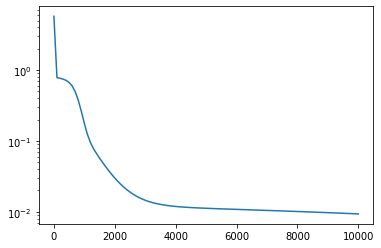

In [284]:
plt.plot(epochs_displayed, losses)
plt.yscale('log')
plt.show()

Compute the analytic solution

In [285]:
def analytic(T, M_z0, lamb, W) :
    K = (M_z0-1) / (M_z0+1)
    Kexp = K*np.exp(-2*lamb*W*T)
    Mz_ana = (1+Kexp) / (1-Kexp)
    return Mz_ana

Plot the estimation and the analytic solution

Extreme values of output after : -1.6845815 -0.50336856


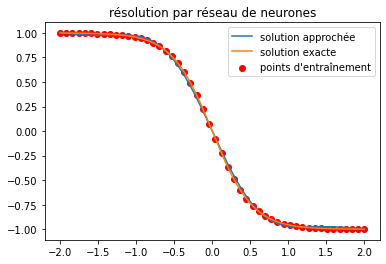

In [286]:
#plot the estimation
nb_plotting_points = 200
plotting_points = np.linspace(t_a,t_b,nb_plotting_points)
plotting_points = tf.convert_to_tensor(plotting_points, dtype=tf.float32)

#neural network estimation
output = model(plotting_points).numpy().reshape((nb_plotting_points))
Mz_NN = M_z0 + (plotting_points-M_z0)*output


print("Extreme values of output after :",min(output), max(output))
#analytic solution
Mz_ana = analytic(plotting_points, M_z0, lamb, W)

#training points
Mz_ana_training = analytic(training_points, M_z0, lamb, W)


plt.plot(plotting_points, Mz_NN, label='solution approchée')
plt.plot(plotting_points, Mz_ana, label='solution exacte')
plt.scatter(training_points, Mz_ana_training, label="points d'entraînement", color='red')

plt.legend()
plt.title('résolution par réseau de neurones')
plt.show()
